In [ ]:
# ----------------------
# ETAPA 1: CARREGAMENTO
# ----------------------
import os
from PIL import Image
import numpy as np

# Diretório base contendo subpastas com imagens
base_path = './images'

# Listas para imagens e rótulos
X = []
y = []

# Classes válidas (left, right, straight, up)
valid_gaze = {'left': 0, 'right': 1, 's': 2, 'u': 3}

# Tamanho fixo para redimensionar as imagens
target_size = (128, 128)

# Função para extrair o gaze a partir do nome do arquivo
def extract_gaze_label(filename):
    try:
        parts = filename.split('_')
        gaze = parts[2][1]  # Terceiro segmento, segundo caractere (ex: 'Rs' -> 's')
        return valid_gaze[gaze] if gaze in valid_gaze else None
    except:
        return None

# Percorrer todos os arquivos nas subpastas
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            label = extract_gaze_label(file)
            if label is not None:
                image_path = os.path.join(root, file)
                try:
                    img = Image.open(image_path).convert('RGB')
                    img = img.resize(target_size)
                    img_np = np.array(img) / 255.0  # Normaliza
                    X.append(img_np)
                    y.append(label)
                except Exception as e:
                    print(f"Erro ao processar {file}: {e}")

# Converter para arrays NumPy
X = np.array(X)
y = np.array(y)

print(f"Total de imagens carregadas: {len(X)}")
print(f"Formato das imagens: {X.shape}")
print(f"Exemplo de rótulos: {np.unique(y)}")


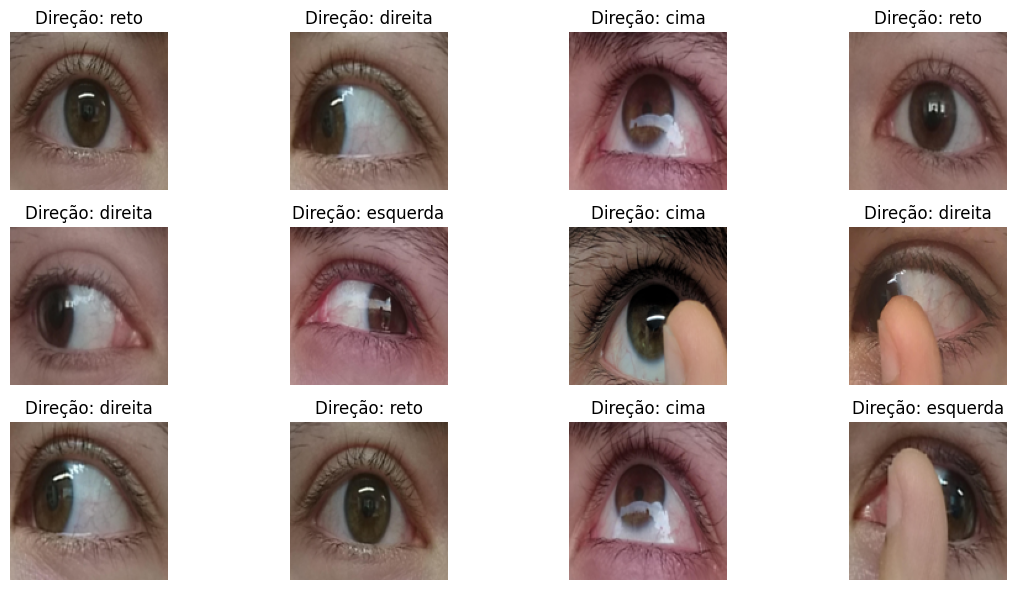

In [17]:
import matplotlib.pyplot as plt

# Número de imagens para exibir (ajuste conforme necessário)
num_images = 12
cols = 4
rows = num_images // cols

plt.figure(figsize=(12, 6))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(X[i])
    label_name = ['esquerda', 'direita', 'reto', 'cima'][y[i]]
    plt.title(f'Direção: {label_name}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# ----------------------
# ETAPA 2: TREINAMENTO
# ----------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Dividir em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Encoding para a saída
num_classes = 4
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

# Arquitetura de camadas da CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Treinamento
model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_data=(X_val, y_val_cat))

# Salvar o modelo
model.save('modelo_gaze.h5')

print("Modelo salvo como modelo_gaze.h5")

/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 28s 65ms/step - accuracy: 0.7294 - loss: 0.7631 - val_accuracy: 0.9028 - val_loss: 0.3302
Epoch 2/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 26s 63ms/step - accuracy: 0.8833 - loss: 0.3912 - val_accuracy: 0.9139 - val_loss: 0.3236
Epoch 3/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.9058 - loss: 0.3242 - val_accuracy: 0.9100 - val_loss: 0.2979
Epoch 4/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.9214 - loss: 0.2685 - val_accuracy: 0.9240 - val_loss: 0.2691
Epoch 5/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.9308 - loss: 0.2389 - val_accuracy: 0.9270 - val_loss: 0.2757
Epoch 6/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 25s 60ms/step - accuracy: 0.9397 - loss: 0.2050 - val_accuracy: 0.9291 - val_loss: 0.2669
Epoch 7/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.9502 - loss: 0.1740 - val_accuracy: 0.9267 - val_loss: 0.2901
Epoch 8/10
418/418 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - accuracy: 0.9484 - loss: 0.1567 - 

Modelo salvo como modelo_gaze.h5


In [ ]:
# ----------------------
# ETAPA 3: LOOP DE PREDIÇÃO COM CÂMERA
# ----------------------
import cv2
import numpy as np
import time
import socket
from tensorflow.keras.models import load_model
import mediapipe as mp

# ========== CARREGAMENTO DO MODELO ==========
model = load_model('modelo_gaze.h5')
target_size = (128, 128)

label_map = {
    0: "esquerda",
    1: "direita",
    2: "reto",
    3: "cima"
}

# ========== ABERTURA DE CONEXÃO SERVIDOR TCP E PEDIDO DE ACEITE==========
HOST = '127.0.0.1'
PORT = 5001
server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
server_socket.bind((HOST, PORT))
server_socket.listen(1)
print(f"Aguardando conexão no socket TCP {HOST}:{PORT}...")
conn, addr = server_socket.accept()
print(f"Cliente conectado: {addr}")

# ========== MEDIAPIPE ==========
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)

# ========== ÍNDICES ==========
LEFT_EYE_IDX = [33, 133, 160, 159, 158, 157, 173, 144]
RIGHT_EYE_IDX = [362, 263, 387, 386, 385, 384, 398, 373]
LEFT_EAR_IDX = [33, 160, 158, 133, 153, 144]
RIGHT_EAR_IDX = [362, 387, 385, 263, 373, 380]
EAR_THRESHOLD = 0.20

# ========== FUNÇÕES ==========
def eye_aspect_ratio(landmarks, indices, w, h):
    def to_point(idx):
        return np.array([landmarks[idx].x * w, landmarks[idx].y * h])
    p1, p2, p3, p4, p5, p6 = [to_point(idx) for idx in indices]
    vertical1 = np.linalg.norm(p2 - p6)
    vertical2 = np.linalg.norm(p3 - p5)
    horizontal = np.linalg.norm(p1 - p4)
    return (vertical1 + vertical2) / (2.0 * horizontal)

def extract_eye_image(frame, landmarks, indices):
    h, w, _ = frame.shape
    eye_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in indices]
    x_coords = [p[0] for p in eye_points]
    y_coords = [p[1] for p in eye_points]
    x_min, x_max = max(min(x_coords) - 5, 0), min(max(x_coords) + 5, w)
    y_min, y_max = max(min(y_coords) - 5, 0), min(max(y_coords) + 5, h)
    eye_crop = frame[y_min:y_max, x_min:x_max]
    if eye_crop.size == 0:
        return None
    eye_img = cv2.resize(eye_crop, target_size)
    eye_img = eye_img.astype(np.float32) / 255.0
    return eye_img, eye_crop

# ========== LOOP PRINCIPAL ==========
cap = cv2.VideoCapture(0)
last_time = 0
interval = 0.3  # 300 ms
last_direction = None

print("Pressione ESC para encerrar...")

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame = cv2.flip(frame, 1)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(rgb_frame)

        current_time = time.time()
        if results.multi_face_landmarks and (current_time - last_time >= interval):
            last_time = current_time
            landmarks = results.multi_face_landmarks[0].landmark
            h, w, _ = frame.shape

            # EAR dos dois olhos
            ear_left = eye_aspect_ratio(landmarks, LEFT_EAR_IDX, w, h)
            ear_right = eye_aspect_ratio(landmarks, RIGHT_EAR_IDX, w, h)
            left_closed = ear_left < EAR_THRESHOLD
            right_closed = ear_right < EAR_THRESHOLD

            left_label = right_label = None
            left_crop = right_crop = None

            if not left_closed:
                left_result = extract_eye_image(frame, landmarks, LEFT_EYE_IDX)
                if left_result:
                    left_eye_img, left_crop = left_result
                    left_input = np.expand_dims(left_eye_img, axis=0)
                    left_pred = model.predict(left_input, verbose=0)
                    left_label = label_map[np.argmax(left_pred)]

            if not right_closed:
                right_result = extract_eye_image(frame, landmarks, RIGHT_EYE_IDX)
                if right_result:
                    right_eye_img, right_crop = right_result
                    right_input = np.expand_dims(right_eye_img, axis=0)
                    right_pred = model.predict(right_input, verbose=0)
                    right_label = label_map[np.argmax(right_pred)]

            # Combina direção
            if left_label in ["esquerda", "direita"]:
                current_direction = left_label
            elif right_label in ["esquerda", "direita"]:
                current_direction = right_label
            else:
                current_direction = "neutra"

            # Se mudou, envia via TCP
            if current_direction != last_direction:
                if current_direction == "esquerda":
                    conn.sendall(b'0\n')
                elif current_direction == "direita":
                    conn.sendall(b'1\n')
                else:
                    conn.sendall(b'2\n')
                print(f"Direção enviada: {current_direction}")
                last_direction = current_direction

            # Mostra apenas os olhos
            if left_crop is not None:
                cv2.imshow("Olho Esquerdo", left_crop)
            if right_crop is not None:
                cv2.imshow("Olho Direito", right_crop)

        # Encerrar com ESC
        if cv2.waitKey(1) & 0xFF == 27:
            break

finally:
    cap.release()
    conn.close()
    server_socket.close()
    cv2.destroyAllWindows()
    print("Conexão encerrada.")

Aguardando conexão no socket TCP 127.0.0.1:5001...
Cliente conectado: ('127.0.0.1', 51141)


I0000 00:00:1753997404.611303 25965575 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4 Pro
W0000 00:00:1753997404.613352 26175365 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753997404.621448 26175362 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Pressione ESC para encerrar...
Direção enviada: direita
Direção enviada: neutra
Direção enviada: direita
Direção enviada: neutra
Direção enviada: direita
Direção enviada: esquerda
Direção enviada: direita
Direção enviada: esquerda
Direção enviada: direita
Direção enviada: esquerda
Direção enviada: direita
Direção enviada: esquerda
Direção enviada: direita
Direção enviada: esquerda
Direção enviada: direita
Direção enviada: esquerda
Direção enviada: direita
Direção enviada: neutra
Direção enviada: direita
Direção enviada: esquerda
Direção enviada: direita
Direção enviada: esquerda
Direção enviada: direita
Direção enviada: esquerda
Direção enviada: neutra
Direção enviada: esquerda
Direção enviada: neutra
Direção enviada: direita
Direção enviada: esquerda
Direção enviada: direita
Direção enviada: neutra
Direção enviada: direita
Direção enviada: neutra
Direção enviada: esquerda
Direção enviada: neutra
Direção enviada: direita
Direção enviada: neutra
Direção enviada: direita
Direção enviada:

KeyboardInterrupt: 